In [14]:
!pip install base

from base import *

from shapely import geometry




In [ ]:
!cd sample_data

In [16]:
!ls

sample_data  tub_1_20-02-23  tub_1_20-02-23.tar.xz


In [17]:
!cd images

/bin/bash: line 0: cd: images: No such file or directory


In [18]:
!tar -xvf  /content/tub_1_20-02-23.tar.xz

Streaming output truncated to the last 5000 lines.
tub_1_20-02-23/record_2601.json
tub_1_20-02-23/record_2619.json
tub_1_20-02-23/record_2623.json
tub_1_20-02-23/record_2649.json
tub_1_20-02-23/record_2663.json
tub_1_20-02-23/record_2669.json
tub_1_20-02-23/record_2671.json
tub_1_20-02-23/record_2679.json
tub_1_20-02-23/record_2683.json
tub_1_20-02-23/record_2687.json
tub_1_20-02-23/record_270.json
tub_1_20-02-23/record_2704.json
tub_1_20-02-23/record_2711.json
tub_1_20-02-23/record_2720.json
tub_1_20-02-23/record_2725.json
tub_1_20-02-23/record_273.json
tub_1_20-02-23/record_2737.json
tub_1_20-02-23/record_2762.json
tub_1_20-02-23/record_2770.json
tub_1_20-02-23/record_2812.json
tub_1_20-02-23/record_2816.json
tub_1_20-02-23/record_2823.json
tub_1_20-02-23/record_2839.json
tub_1_20-02-23/record_284.json
tub_1_20-02-23/record_2856.json
tub_1_20-02-23/record_2867.json
tub_1_20-02-23/record_2891.json
tub_1_20-02-23/record_2921.json
tub_1_20-02-23/record_2924.json
tub_1_20-02-23/record_29

In [19]:
#images_folder_path = './data/fisheye_camera_calibration/'
import glob
import os
images_folder_path = '/content/tub_1_20-02-23'
img_list = glob.glob(os.path.join(images_folder_path,'*.jpg'))
print(len(img_list))

#sort list by frame number 
img_list = sorted(img_list, key=lambda x: int(x.split('/')[-1].split('_')[0]))
img_list[:10]


6314


['/content/tub_1_20-02-23/1_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/2_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/3_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/4_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/5_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/6_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/7_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/8_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/9_cam-image_array_.jpg',
 '/content/tub_1_20-02-23/10_cam-image_array_.jpg']

In [20]:
import numpy as np


K = np.array([
    [ 340.56819732,    0.        ,  307.01297403],
    [   0.        ,  319.22996275,  237.70091279],
    [   0.        ,    0.        ,    1.        ]
])


D = np. array([
    [-0.02025494],
    [ 0.00573737],
    [-0.02515587],
    [ 0.01317606]
])


#scale only the top two rows.
x_scale = .25
scales = np.array([x_scale, x_scale, 1])
Kp = (K.T *  scales).T
Kp



array([[85.14204933,  0.        , 76.75324351],
       [ 0.        , 79.80749069, 59.4252282 ],
       [ 0.        ,  0.        ,  1.        ]])

In [21]:
#Pull in the camera properties we calculated in the calibrate_camera notebook
w, h = 160,120
mtx = Kp

focal_length = fx, fy = mtx[0,0], mtx[1,1]
print('focal length: {}'.format(focal_length))

optical_axis_center = cx, cy = mtx[0,2], mtx[1,2]
print('optical_axis_center: {}'.format(optical_axis_center))

k1, k2, k3, k4 = D


focal length: (85.14204933, 79.8074906875)
optical_axis_center: (76.7532435075, 59.4252281975)


In [ ]:
def get_key_points(img):
    #first frame
    detector = cv2.FastFeatureDetector_create(threshold=25, nonmaxSuppression=True)
    prev_points = detector.detect(img)
    points = np.array([x.pt for x in prev_points], dtype=np.float32)
    return points

In [ ]:
def track_key_points(prev_img, next_img, prev_points):
    
    lk_params = dict(winSize  = (21, 21),
                     criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    next_points, status, error = cv2.calcOpticalFlowPyrLK(prev_img, 
                                                          next_img, 
                                                          prev_points, 
                                                          None, 
                                                          winSize=(21, 21),
                                                          criteria =(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01)
                                                         )
    status = status.reshape(status.shape[0])
    prev_points = prev_points[status == 1]
    next_points = next_points[status == 1]

    return prev_points, next_points

In [ ]:
import cv2
prev_img = cv2.imread(img_list[0], 0)
prev_points = get_key_points(prev_img)

next_img = cv2.imread(img_list[1], 0)

plot_data = [{'name': 'prev', 'array': prev_img},
             {'name': 'next', 'array': next_img}]
#show_imgs(plot_data)

In [25]:


prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
len(prev_points)



135

In [ ]:
def calculate_possition_change(prev_img, next_img, prev_points, next_points, 
                               fx, optical_axis_center):
    """
    Calculate the relative rotaion and translation between images.
    """
    
    #filter points to only those trackable between images
    prev_points, next_points = track_key_points(prev_img, next_img, prev_points)
    
    
    E, mask = cv2.findEssentialMat(prev_points, 
                                   next_points, 
                                   focal=fx, 
                                   pp=optical_axis_center, 
                                   method=cv2.RANSAC, 
                                   prob=0.999, 
                                   threshold=1.0)
    
    _, R, t, mask = cv2.recoverPose(E, 
                                    next_points, 
                                    prev_points, 
                                    focal=fx, 
                                    pp = optical_axis_center)
    
    
    return R, t #relative rotation and translation


In [27]:
R, t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)
print('relative rotation matrix:')
print((np.round(R, 3)))

print('relative translation: {}')
print(t)

relative rotation matrix:
[[ 1.  0. -0.]
 [-0.  1. -0.]
 [ 0.  0.  1.]]
relative translation: {}
[[ 0.30412819]
 [ 0.44492956]
 [-0.84234419]]


In [ ]:
def update_possition(prev_R, prev_t, R, t):

    #absolute_scale = self.getAbsoluteScale(frame_id)
    absolute_scale = 1
    next_t = prev_t + absolute_scale*prev_R.dot(t) 
    next_R = R.dot(prev_R)
    
    return next_t, next_R

In [ ]:
def undistort(distorted_img, K, D, undistorted_size=None, R=np.eye(3) * np.array([1,1,1.5])):
    """Undistort an image using the fisheye model"""

    if undistorted_size is None:
        undistorted_size = (distorted_img.shape[1], distorted_img.shape[0])

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(
        K,
        D,
        R,
        K,
        undistorted_size, 
        cv2.CV_16SC2
    )

    undistorted_img = cv2.remap(
        distorted_img,
        map1,
        map2,
        interpolation=cv2.INTER_LINEAR,
        borderMode=cv2.BORDER_CONSTANT
    )

    return undistorted_img

In [ ]:
prev_t = np.zeros((3, 1))
#prev_R = np.zeros((3,3))  + 1

t_log = [prev_t]

#first frame
prev_img = cv2.imread(img_list[0])
prev_img = undistort(prev_img, Kp, D)
prev_points = get_key_points(prev_img)


#second_frame
next_img = cv2.imread(img_list[1])
next_img = undistort(next_img, Kp, D)
prev_points, next_points = track_key_points(prev_img, next_img, prev_points)

#for the second frame, the relative change is the absolute change
prev_R, prev_t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)

#log the translation
t_log.append(prev_t)

#move next to previous
prev_img = next_img
prev_points = next_points


for i, img in enumerate(img_list[2:100]):
    next_img = cv2.imread(img)
    next_img = undistort(next_img, Kp, D)
    prev_points, next_points = track_key_points(prev_img,next_img, prev_points)
    #print(len(prev_points))
    R, t = calculate_possition_change(prev_img, next_img, prev_points, next_points,
                                  fx, optical_axis_center)

    prev_t, prev_R = update_possition(prev_R, prev_t, R, t)

    t_log.append(prev_t)
    
    if(len(next_points) < 100):
        next_points  = get_key_points(next_img)

    #move next to previous
    prev_img = next_img
    prev_points = next_points


In [36]:

import pandas as pd
t_arr = np.array(t_log)
t_arr = t_arr.reshape(t_arr.shape[:2])
df = pd.DataFrame(t_arr, columns=['x', 'y', 'z'])
df.head()



,x,y,z
0,0.000000,0.000000,0.000000
1,-0.263791,-0.386391,0.883808
2,-0.564181,0.563120,0.974337
3,-0.759435,0.358894,1.933591
4,-0.845426,-0.628961,1.804183


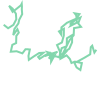

In [49]:


coords = [(arr[0], arr[1]) for arr in t_arr]
geometry.LineString(coords)



In [38]:


import shutil

for i, src_path in enumerate(img_list[:470]):
    dest_path = os.path.join('/content/images', str(i).zfill(4)+'.jpg')
    shutil.copyfile(src_path, dest_path)



FileNotFoundError: ignored